# Assignment: Segmenting and Clustering Neighborhoods in Sandton
Notebook to scrape and understand Neighbourhood information

### Install and Import Packages

In [1]:
# install scraping package
#!conda install -c conda-forge beautifulsoup4

# library import Section 
import numpy as np
import pandas as pd
from pandas import DataFrame

import requests
from bs4 import BeautifulSoup
# from tabulate import tabulate

In [2]:
import requests # library to handle requests
import random # library for random number generation

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.1               |             py_0         575 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

### Scrape the input data
#### Build the Scaping Function

In [9]:
def extracturl(url,c):
    import requests

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)

    dfs = pd.read_html(r.text)

    tables = pd.read_html(r.text)
    df = tables[c]
    print('Inital shape: ' + str(df.shape))
    df
    return(df)

In [10]:
urld='https://businesstech.co.za/news/lifestyle/366416/the-most-expensive-cities-in-south-africa-in-2020-pretoria-vs-joburg-vs-cape-town-vs-durban/'

In [11]:
df=extracturl(urld,1)

Inital shape: (4, 6)


In [13]:
# df.columns = df.iloc[0]
# df = df[1:]
df=df.set_index('City')

In [14]:
df

,Average disposable salary,Monthly transport costs,Rent for a 1-bedroom apartment in the city centre,Basic utilities,Meal for two people at a restaurant
City,,,,,
Pretoria,R19 220,R1 590,R5 090,R1 400,R485
Johannesburg,R17 360,R1 330,R6 720,R800,R500
Cape Town,R18 300,R425,R11 170,R550,R600
Durban,R15 000,R375,R9 940,R1 230,R410


#### Define the extraction URLs

In [15]:
urlsandton = "https://census2011.adrianfrith.com/place/798013"
urlu='https://census2011.adrianfrith.com/place/599054'
url='https://census2011.adrianfrith.com/place/199041'

#### Extract the URLs

In [31]:
df_ct=extracturl(url,3)
df_ct['Main Place']='Cape Town'
df_ct.head(3)

Inital shape: (122, 3)


,Name,Population,Area (km²),Main Place
0,Airlie,312,0.26,Cape Town
1,Alphen,754,2.32,Cape Town
2,Bakoven,2209,1.35,Cape Town


In [32]:
df_s=extracturl(urlsandton,3)
df_s['Main Place']='Sandton'
df_s.head(3)

Inital shape: (62, 3)


,Name,Population,Area (km²),Main Place
0,Atholl,4153,2.24,Sandton
1,Barlow Park,234,0.51,Sandton
2,Beverley,3828,2.70,Sandton


In [33]:
df_u=extracturl(urlu,3)
df_u['Main Place']='Durban'
df_u.head(3)

Inital shape: (71, 3)


,Name,Population,Area (km²),Main Place
0,Athlone,2851,1.38,Durban
1,Athlone Park,3818,4.35,Durban
2,Avoca,7568,2.53,Durban


In [34]:
df_u['address']=df_u['Name']+','+df_u['Main Place']
print(' SubPlaces Extract')
df_s['address']=df_s['Name']+','+df_s['Main Place']
df_ct['address']=df_ct['Name']+','+df_ct['Main Place']

 SubPlaces Extract


## Setup foursquare API

In [35]:
CLIENT_ID = 'D20PTFA5ZWZHCWP0UD4OISYG5GACXPGCFWH0WBO42RGINHX3' # your Foursquare ID
CLIENT_SECRET = 'JYCOZZ1FYSL5YIU0PL1UDHM25DCIF4P41UG0YQLFKGVLQK2O' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D20PTFA5ZWZHCWP0UD4OISYG5GACXPGCFWH0WBO42RGINHX3
CLIENT_SECRET:JYCOZZ1FYSL5YIU0PL1UDHM25DCIF4P41UG0YQLFKGVLQK2O


## Create Geolocation Functions

In [36]:
import time

def get_coordinates(address, timeout=5):
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(address, timeout=timeout)
    time.sleep(1)
    if not location:
        return None, None
    return str(location.latitude), str(location.longitude)

In [37]:
## Test GPS Functions

print(get_coordinates('Sandton,Bramley Park'))
# print(locate('Sandton,Lonehill'))

('-26.1247222', '28.0788889')


In [38]:
## Lookup Addresses
df_u['Coords'] = df_u['address'].apply(get_coordinates)
print('Durban Extract complete')
df_s['Coords'] = df_s['address'].apply(get_coordinates)
print('Sandton Extract complete')

df_ct['Coords'] = df_ct['address'].apply(get_coordinates)

print('Cape Town Extract complete')
df_ct_xy=df_ct
df_s_xy=df_s
df_u_xy=df_u
print('Lookup Complete')

Durban Extract complete
Sandton Extract complete
Cape Town Extract complete
Lookup Complete


## Split Coords into Lat and Long
### Define the function

In [39]:
def splitxy(dataf):
    d = dataf["Coords"].astype(str).str.split(',',expand=True) 

    d[0]=d[0].str.replace("(", '')
    d[0]=d[0].str.replace("'", '')
    d[1]=d[1].apply(str).str.replace(")", '')
    d[1]=d[1].str.replace("'", '')


    dataf["Latitude"]=d[0]
    dataf["Longitude"]=d[1]

    
    return dataf

In [40]:
splitxy(df_u_xy)
splitxy(df_ct_xy)
splitxy(df_s_xy)
print('Split XY done')

Split XY done


## Remove None Fields


In [41]:
df_s_xy=df_s_xy[df_s_xy['Latitude'] != 'None']
df_ct_xy=df_ct_xy[df_ct_xy['Latitude'] != 'None']
df_u_xy=df_u_xy[df_u_xy['Latitude'] != 'None']
print('done removing None Fields')

done removing None Fields


In [42]:
# Check dataframe
df_ct_xy.head()

,Name,Population,Area (km²),Main Place,address,Coords,Latitude,Longitude
0,Airlie,312,0.26,Cape Town,"Airlie,Cape Town","(-34.041163, 18.435566)",-34.041163,18.435566
1,Alphen,754,2.32,Cape Town,"Alphen,Cape Town","(-34.008307, 18.43920808836982)",-34.008307,18.43920808836982
2,Bakoven,2209,1.35,Cape Town,"Bakoven,Cape Town","(-33.96, 18.3827778)",-33.96,18.3827778
3,Bantry Bay,820,0.38,Cape Town,"Bantry Bay,Cape Town","(-33.9281512, 18.3789695)",-33.9281512,18.3789695
5,Bel Ombre,1045,2.02,Cape Town,"Bel Ombre,Cape Town","(-34.0000223, 18.4074868)",-34.0000223,18.4074868


## Folium map view of Sandton

In [43]:
# create map of Sandton using latitude and longitude 
map_sandton = folium.Map(location=[-26.064634, 28.034603], zoom_start=12, tiles='cartodbpositron')

# add markers to map
for lat, lng, Name, Population in zip(df_s_xy['Latitude'], df_s_xy['Longitude'], df_s_xy['Name'], df_s_xy['Population']):
    label = '{}, {}'.format(Name, Population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_sandton)  
    
map_sandton

In [44]:
# create map of Sandton using latitude and longitude values
map_ct = folium.Map(location=[-34.041163, 18.435566], zoom_start=11,tiles='cartodbpositron')

# add markers to map
for lat, lng, Name, Population in zip(df_ct_xy['Latitude'], df_ct_xy['Longitude'], df_ct_xy['Name'], df_ct_xy['Population']):
    label = '{}, {}'.format(Name, Population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#e35e46',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ct)  
    
map_ct

In [45]:
# create map of Durban using latitude and longitude values
map_umh = folium.Map(location=[-29.8587, 31.0218], zoom_start=11, tiles='cartodbpositron')

# add markers to map
for lat, lng, Name, Population in zip(df_u_xy['Latitude'], df_u_xy['Longitude'], df_u_xy['Name'], df_u_xy['Population']):
    label = '{}, {}'.format(Name, Population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#46e34e',
        fill_opacity=0.7,
        parse_html=False).add_to(map_umh)  
    
map_umh

##   Explore Neighborhoods

In [46]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [47]:
## Sandton Neighbourhood
sandton_venues = getNearbyVenues(names=df_s_xy['Name'],
                                   latitudes=df_s_xy['Latitude'],
                                   longitudes=df_s_xy['Longitude']
                                  )


Atholl
Beverley
Bramley North
Bramley Park
Broadacres AH
Bryanston
Buccleuch
Douglasdale
Duxberry
Eastgate
Edenburg
Fourways
Fourways Gardens
Gallo Manor
Hurlingham
Hurlingham Gardens
Hyde Park
Illovo
Inanda
Kelvin
Kleve Hill Park
Leeuwkop Prison
Linbro Park AH
Lone Hill
Lyme Park
Magaliessig
Marlboro Gardens
Moodie Hill
Morningside
Morningside Manor
New Brighton
Norscot
Parkmore
Paulshof
Petervale
Pine Slopes AH
River Club
Rivonia
Sandhurst
Sandown
Simba
Strathavon
Sunninghill
The Woodlands
Wendywood
Wierda Valley
Witkoppen
Woodmead
Wynberg


In [48]:
## Durban Neighbourhood
dbn_venues = getNearbyVenues(names=df_u_xy['Name'],
                                   latitudes=df_u_xy['Latitude'],
                                   longitudes=df_u_xy['Longitude']
                                  )


Athlone
Athlone Park
Avoca
Bayhead
Beachwood Mangroves
Bellair
Berea
Bluff
Bonela
Briardene
Broadway
Carrington Heights
Cato Crest
Chesterville
Clairwood
Clare Hills
Congella
Durban Central
Durban International Airport
Essenwood
Fynnlands
Glen Anil
Glen Ashley
Glen Hill
Glenmore
Greenwood Park
Hillary
Isipingo Beach
Isipingo Rail
Joe Slovo
Kenneth Stainbank
Kenville
Lotus Park
Memorial Park
Mobeni East
Mobeni Heights
Mobeni West
Montclair
Mount Vernon
Mowat
North Beach
Palmiet
Park Hill
Point
Prospect Hall
Prospecton
Red Hill
Reservoir Hills
Ridgeview
Sapref
Sea Cow Lake
Sea View
Sherwood
South Beach
Sparks
Springfield
Stamford Hill
Umbogintwini
Umgeni Business Park
Umgeni Park
uMkumbaan
Virginia
Wiggins
Woodhaven
Woodlands


In [49]:
## Cape Town Neighbourhood

ct_venues = getNearbyVenues(names=df_ct_xy['Name'],
                                   latitudes=df_ct_xy['Latitude'],
                                   longitudes=df_ct_xy['Longitude']
                                  )

Airlie
Alphen
Bakoven
Bantry Bay
Bel Ombre
Belle Constantia
Bergvliet
Bishopscourt
Buckingham
Cafda Village
Camps Bay
Claremont
Clifton
Constantia
Constantia Heights
Constantia Vale
Constantia Village
Crawford
Deurdrif
Devil's Peak Estate
Diep River
Dreyersdal
Eagles Nest
Eden Klein
Edward
Elfindale
Fairways
Ferness
Fir Grove
Foreshore
Frere Estate
Fresnaye
Gardens
Glen Alpine
Glen Valley
Glen View
Green Point
Heathfield
Hope of Constantia
Kalk Bay
Kenilworth
Kensington
Kirstenbosch National Botanical Gardens
Kirstenhof
Lansdowne
Lavender Hill
Maitland
Maitland Garden Village
Meadowridge
Mouille Point
Mowbray
Ndabeni
Newlands
Newlands Forest
Nova Constantia
Observatory
Oranjezicht
Ottery
Ottery East
Pinati
Pinelands
Plumstead
Pollsmoor
Retreat
Rondebosch
Rondebosch East
Rosebank
Royal Cape
Rust-En-Vrede
Salt River
Schotschekloof
Sea Point
Seawinds
Sheraton Park
Sillery
Silverhurst
Silvermine
Southfield
Steenberg
Steenberg Estate
Sunlands
Sweet Valley
Tamboerskloof
Three Anchor Bay
Toka

## Group Venues data

In [50]:
sandton_venues.groupby(['Venue Category'])['Venue Category'].count()
ct_venues.groupby(['Venue Category'])['Venue Category'].count()
dbn_venues.groupby(['Venue Category'])['Venue Category'].count()
print('done')

done


Portuguese Restaurant      16
Indian Restaurant          14
Italian Restaurant         11
Seafood Restaurant          7
Chinese Restaurant          6
Sushi Restaurant            4
Asian Restaurant            3
Cuban Restaurant            2
Comfort Food Restaurant     2
Japanese Restaurant         1
Name: Venue Category, dtype: int64


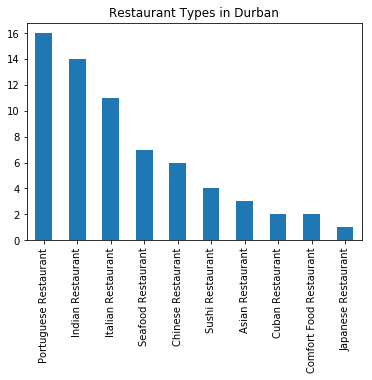

In [51]:
%matplotlib inline
dbn_venues=dbn_venues[dbn_venues['Venue Category'].str.contains("Restaurant")]
dbn_venues=dbn_venues[dbn_venues['Venue Category'] != 'Restaurant']
dbn_venues=dbn_venues[dbn_venues['Venue Category'] != 'Fastfood Restaurant']
dbn_venues=dbn_venues[dbn_venues['Venue Category'] != 'Fast Food Restaurant']
print(dbn_venues['Venue Category'].value_counts().nlargest(10))
ax = dbn_venues['Venue Category'].value_counts().nlargest(10).plot(kind='bar',sharex=True,sharey=True,title='Restaurant Types in Durban')

Italian Restaurant          38
Portuguese Restaurant       16
Indian Restaurant           15
Chinese Restaurant          13
Mediterranean Restaurant     9
Seafood Restaurant           8
French Restaurant            7
Asian Restaurant             6
Japanese Restaurant          4
Greek Restaurant             4
Name: Venue Category, dtype: int64


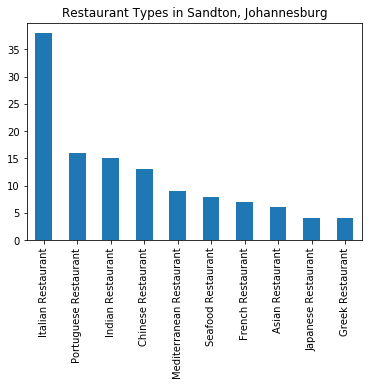

In [52]:
%matplotlib inline
sandton_venues=sandton_venues[sandton_venues['Venue Category'].str.contains("Restaurant")]
sandton_venues=sandton_venues[sandton_venues['Venue Category'] != 'Restaurant']
sandton_venues=sandton_venues[sandton_venues['Venue Category'] != 'Fastfood Restaurant']
sandton_venues=sandton_venues[sandton_venues['Venue Category'] != 'Fast Food Restaurant']
print(sandton_venues['Venue Category'].value_counts().nlargest(10))
ax=sandton_venues['Venue Category'].value_counts().nlargest(10).plot(kind='bar',sharex=True,sharey=True,title='Restaurant Types in Sandton, Johannesburg')

Italian Restaurant       36
Seafood Restaurant       34
Sushi Restaurant         20
Indian Restaurant        19
Portuguese Restaurant    16
Thai Restaurant          16
French Restaurant        13
Mexican Restaurant       10
American Restaurant       7
Chinese Restaurant        6
Name: Venue Category, dtype: int64


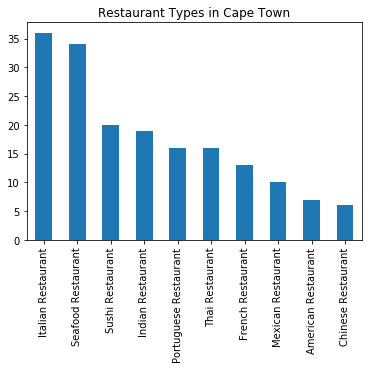

In [53]:
%matplotlib inline
ct_venues=ct_venues[ct_venues['Venue Category'].str.contains("Restaurant")]
ct_venues=ct_venues[ct_venues['Venue Category'] != 'Restaurant']
ct_venues=ct_venues[ct_venues['Venue Category'] != 'Fastfood Restaurant']
ct_venues=ct_venues[ct_venues['Venue Category'] != 'Fast Food Restaurant']
print(ct_venues['Venue Category'].value_counts().nlargest(10))
ax=ct_venues['Venue Category'].value_counts().nlargest(10).plot(kind='bar',sharex=True,sharey=True,title='Restaurant Types in Cape Town')

## Clustering

In [54]:
# one hot encoding
sandton_venues_onehot = pd.get_dummies(sandton_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sandton_venues_onehot['Neighborhood'] = sandton_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [sandton_venues_onehot.columns[-1]] + list(sandton_venues_onehot.columns[:-1])
sandton_venues_onehot = sandton_venues_onehot[fixed_columns]
sandton_venues_onehot.head(3)

,Neighborhood,African Restaurant,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Eastern European Restaurant,French Restaurant,German Restaurant,Greek Restaurant,...,Molecular Gastronomy Restaurant,Moroccan Restaurant,Portuguese Restaurant,Seafood Restaurant,South Indian Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vietnamese Restaurant
5,Atholl,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
13,Atholl,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
16,Atholl,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# one hot encoding
ct_venues_onehot = pd.get_dummies(ct_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ct_venues_onehot['Neighborhood'] = ct_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ct_venues_onehot.columns[-1]] + list(ct_venues_onehot.columns[:-1])
ct_venues_onehot = ct_venues_onehot[fixed_columns]
ct_venues_onehot.head(3)

,Neighborhood,African Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dumpling Restaurant,...,Moroccan Restaurant,New American Restaurant,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant
7,Airlie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10,Alphen,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,Bakoven,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [56]:
# one hot encoding
dbn_venues_onehot = pd.get_dummies(dbn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dbn_venues_onehot['Neighborhood'] = dbn_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [dbn_venues_onehot.columns[-1]] + list(dbn_venues_onehot.columns[:-1])
dbn_venues_onehot = dbn_venues_onehot[fixed_columns]
dbn_venues_onehot.head(3)

,Neighborhood,Asian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Modern European Restaurant,Portuguese Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant
13,Athlone,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
29,Athlone Park,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
40,Beachwood Mangroves,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [57]:
sandton_grouped = sandton_venues_onehot.groupby('Neighborhood').mean().reset_index()
ct_grouped = ct_venues_onehot.groupby('Neighborhood').mean().reset_index()
dbn_grouped = dbn_venues_onehot.groupby('Neighborhood').mean().reset_index()

In [58]:
sandton_grouped.groupby('Neighborhood').count()
ct_grouped.groupby('Neighborhood').count()
dbn_grouped.groupby('Neighborhood').count()

,Asian Restaurant,Chinese Restaurant,Comfort Food Restaurant,Cuban Restaurant,French Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Modern European Restaurant,Portuguese Restaurant,Seafood Restaurant,Sushi Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant
Neighborhood,,,,,,,,,,,,,,,
Athlone,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Athlone Park,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Beachwood Mangroves,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Berea,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Broadway,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Carrington Heights,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Chesterville,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Clairwood,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Congella,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [59]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
s_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
s_neighborhoods_venues_sorted['Neighborhood'] = sandton_grouped['Neighborhood']

for ind in np.arange(sandton_grouped.shape[0]):
    s_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sandton_grouped.iloc[ind, :], num_top_venues)

s_neighborhoods_venues_sorted.head()
s_neighborhoods_venues_sorted.to_csv('s_venues.csv')

In [61]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
ct_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
ct_neighborhoods_venues_sorted['Neighborhood'] = ct_grouped['Neighborhood']

for ind in np.arange(ct_grouped.shape[0]):
    ct_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ct_grouped.iloc[ind, :], num_top_venues)

ct_neighborhoods_venues_sorted.head()
ct_neighborhoods_venues_sorted.to_csv('ct_venues.csv')

In [62]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
dbn_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
dbn_neighborhoods_venues_sorted['Neighborhood'] = dbn_grouped['Neighborhood']

for ind in np.arange(dbn_grouped.shape[0]):
    dbn_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dbn_grouped.iloc[ind, :], num_top_venues)

dbn_neighborhoods_venues_sorted.head()
dbn_neighborhoods_venues_sorted.to_csv('dbn_venues.csv')

## Optimse k using Elbow Method

In [65]:
sandton_grouped_clustering = sandton_grouped.drop('Neighborhood', 1)
dbn_grouped_clustering = dbn_grouped.drop('Neighborhood', 1)
ct_grouped_clustering = ct_grouped.drop('Neighborhood', 1)

In [66]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def elbow(a,b):
#     a = a.drop('Neighborhood', 1)
    sse = {}
    for k in range(1, 14):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(a)
    #     data["clusters"] = kmeans.labels_
        #print(data["clusters"])
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.title("Elbow Method - " + b)
    plt.show()
    return()

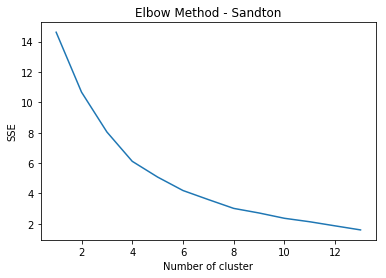

()

In [67]:
elbow(sandton_grouped_clustering, 'Sandton')

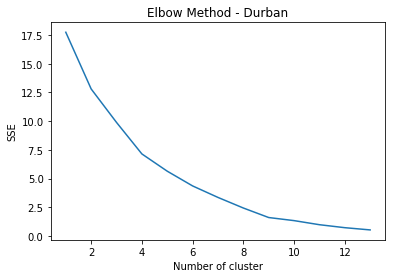

()

In [68]:
elbow(dbn_grouped_clustering, 'Durban')

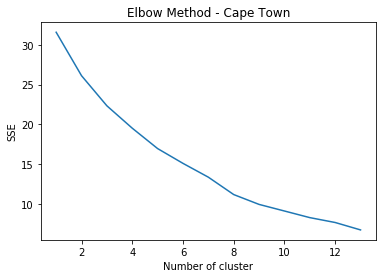

()

In [69]:
elbow(ct_grouped_clustering, 'Cape Town')

## Run the Clustering Model

In [70]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
s_kclusters = 8
d_kclusters = 9
c_kclusters = 9

sandton_grouped_clustering = sandton_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans_s = KMeans(n_clusters=s_kclusters, random_state=0).fit(sandton_grouped_clustering)
# check cluster labels generated for each row in the dataframe
print(kmeans_s.labels_[0:9] )


dbn_grouped_clustering = dbn_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans_dbn = KMeans(n_clusters=d_kclusters, random_state=0).fit(dbn_grouped_clustering)
# check cluster labels generated for each row in the dataframe
print(kmeans_dbn.labels_[0:9] )

ct_grouped_clustering = ct_grouped.drop('Neighborhood', 1)
# run k-means clustering
kmeans_ct = KMeans(n_clusters=c_kclusters, random_state=0).fit(ct_grouped_clustering)
# check cluster labels generated for each row in the dataframe
print(kmeans_ct.labels_[0:9] )

[5 2 4 4 4 2 7 5 6]
[5 5 4 3 3 1 8 1 2]
[5 5 3 5 6 2 3 5 3]


## Step 16 - Add the Cluster Labels

In [71]:
# add clustering labels
ct_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_ct.labels_)

ct_merged = df_ct_xy
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ct_merged = ct_merged.join(ct_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')
ct_merged.head(3) # check the last columns!
ct_merged.to_csv('ct_clusters.csv')

In [72]:
# add clustering labels
dbn_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_dbn.labels_)

dbn_merged = df_u_xy
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dbn_merged = dbn_merged.join(dbn_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')
dbn_merged.head(3) # check the last columns!
dbn_merged.to_csv('dbn_clusters.csv')

In [73]:
# add clustering labels
s_neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans_s.labels_)

sandton_merged = df_s_xy
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
sandton_merged = sandton_merged.join(s_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Name')
# sandton_merged.head(3) # check the last columns!
sandton_merged.to_csv('s_clusters.csv')

## Cluster 0

In [74]:
sandton_merged.loc[sandton_merged['Cluster Labels'] == 0, sandton_merged.columns[[1] + list(range(5, sandton_merged.shape[1]))]]
dbn_merged.loc[dbn_merged['Cluster Labels'] == 0, dbn_merged.columns[[1] + list(range(5, dbn_merged.shape[1]))]]
ct_merged.loc[ct_merged['Cluster Labels'] == 0, ct_merged.columns[[1] + list(range(5, ct_merged.shape[1]))]]

,Population,Coords,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
21,73,"(-34.02114685, 18.444388267032494)",-34.02114685,18.444388267032494,0.0,Italian Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant
26,1859,"(-33.93762315, 18.430208618501993)",-33.93762315,18.430208618501993,0.0,Italian Restaurant,Sushi Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Argentinian Restaurant
108,987,"(54.5602733, -1.3004914)",54.5602733,-1.3004914,0.0,Italian Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant
121,5122,"(-33.932546, 18.435048)",-33.932546,18.435048,0.0,Italian Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant


## Cluster 1

In [75]:
sandton_merged.loc[sandton_merged['Cluster Labels'] == 1, sandton_merged.columns[[1] + list(range(5, sandton_merged.shape[1]))]]
dbn_merged.loc[dbn_merged['Cluster Labels'] == 1, dbn_merged.columns[[1] + list(range(5, dbn_merged.shape[1]))]]
ct_merged.loc[ct_merged['Cluster Labels'] == 1, ct_merged.columns[[1] + list(range(5, ct_merged.shape[1]))]]

,Population,Coords,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
18,909,"(-34.0283333, 18.4155556)",-34.0283333,18.4155556,1.0,French Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant
20,149,"(-34.0283333, 18.4155556)",-34.0283333,18.4155556,1.0,French Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant
29,18,"(-34.0071563, 18.4040226)",-34.0071563,18.4040226,1.0,Tapas Restaurant,French Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant
105,2568,"(-34.0608333, 18.4416667)",-34.0608333,18.4416667,1.0,French Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant


## Cluster 2

In [76]:
sandton_merged.loc[sandton_merged['Cluster Labels'] == 2, sandton_merged.columns[[1] + list(range(5, sandton_merged.shape[1]))]]
dbn_merged.loc[dbn_merged['Cluster Labels'] == 2, dbn_merged.columns[[1] + list(range(5, dbn_merged.shape[1]))]]
ct_merged.loc[ct_merged['Cluster Labels'] == 2, ct_merged.columns[[1] + list(range(5, ct_merged.shape[1]))]]

,Population,Coords,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
10,9964,"(-34.0608333, 18.4844444)",-34.0608333,18.4844444,2.0,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant
47,125,"(-25.8279011, 28.3047556)",-25.8279011,28.3047556,2.0,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant
68,3580,"(-33.9438889, 18.415)",-33.9438889,18.415,2.0,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant
69,5089,"(-34.0131526, 18.5091531)",-34.0131526,18.5091531,2.0,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant
70,2874,"(-34.0131526, 18.5091531)",-34.0131526,18.5091531,2.0,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant
74,5122,"(-33.9919876, 18.5179526)",-33.9919876,18.5179526,2.0,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant


In [77]:
sandton_merged.loc[sandton_merged['Cluster Labels'] == 3, sandton_merged.columns[[1] + list(range(5, sandton_merged.shape[1]))]]
dbn_merged.loc[dbn_merged['Cluster Labels'] == 3, dbn_merged.columns[[1] + list(range(5, dbn_merged.shape[1]))]]
ct_merged.loc[ct_merged['Cluster Labels'] == 3, ct_merged.columns[[1] + list(range(5, ct_merged.shape[1]))]]

,Population,Coords,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,2209,"(-33.96, 18.3827778)",-33.96,18.3827778,3.0,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Japanese Restaurant
11,2773,"(-33.9525, 18.3847222)",-33.9525,18.3847222,3.0,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,American Restaurant,Indian Restaurant
16,507,"(-33.9352848, 18.3790703)",-33.9352848,18.3790703,3.0,Seafood Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant
25,1381,"(-34.0208333, 18.4583333)",-34.0208333,18.4583333,3.0,Thai Restaurant,Seafood Restaurant,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Dim Sum Restaurant
36,268,"(-33.9229547, 18.4382413)",-33.9229547,18.4382413,3.0,Italian Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Argentinian Restaurant
38,1081,"(-32.9911858, 27.9016821)",-32.9911858,27.9016821,3.0,Seafood Restaurant,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,American Restaurant
42,250,"(-33.9477778, 18.3847222)",-33.9477778,18.3847222,3.0,Seafood Restaurant,Japanese Restaurant,Italian Restaurant,American Restaurant,Indian Restaurant
43,689,"(-33.9477778, 18.3847222)",-33.9477778,18.3847222,3.0,Seafood Restaurant,Japanese Restaurant,Italian Restaurant,American Restaurant,Indian Restaurant
49,700,"(-34.12715345, 18.44684718211851)",-34.12715345,18.44684718211851,3.0,Seafood Restaurant,Italian Restaurant,Cuban Restaurant,English Restaurant,French Restaurant
75,14198,"(-33.9316667, 18.5127778)",-33.9316667,18.5127778,3.0,Seafood Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Indian Restaurant,American Restaurant


## Durban Non-Thai Clusters

In [78]:
dbn_merged.loc[dbn_merged['Cluster Labels'] == 4, dbn_merged.columns[[1] + list(range(5, dbn_merged.shape[1]))]]

,Population,Coords,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
4,201,"(-29.80071605, 31.042382266008637)",-29.80071605,31.042382266008637,4.0,Indian Restaurant,Turkish Restaurant,Thai Restaurant,Tapas Restaurant,Sushi Restaurant
49,1612,"(-29.7983333, 31.0336111)",-29.7983333,31.0336111,4.0,Indian Restaurant,Turkish Restaurant,Thai Restaurant,Tapas Restaurant,Sushi Restaurant
52,19143,"(-29.794942, 30.9353627)",-29.794942,30.9353627,4.0,Indian Restaurant,Turkish Restaurant,Thai Restaurant,Tapas Restaurant,Sushi Restaurant
64,6871,"(-29.8053559, 31.0189902)",-29.8053559,31.0189902,4.0,Indian Restaurant,Chinese Restaurant,Turkish Restaurant,Thai Restaurant,Tapas Restaurant


In [79]:
# create map of Sandton using latitude and longitude values
map_sandton_cluster = folium.Map(location=[-26.064634, 28.034603], zoom_start=12, tiles='cartodbpositron')
from folium.plugins import HeatMap

sandton_merged['marker_color'] = pd.cut(sandton_merged['Cluster Labels'], bins=9, 
                               labels=['black','darkblue','red', 'blue', 'green', 'purple','yellow','darkgreen','pink'])

# add markers to map
for lat, lng, Name, Population, cluster, color in zip(sandton_merged['Latitude'], sandton_merged['Longitude'], sandton_merged['Name'], sandton_merged['Population'],sandton_merged['Cluster Labels'],sandton_merged['marker_color']):
    label = '{}, {}, {}'.format(Name, Population,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=7,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.5,
        parse_html=False).add_to(map_sandton_cluster)  
        
map_sandton_cluster

In [80]:
# create map of Durban using latitude and longitude values
map_dbn_cluster = folium.Map(location=[-29.8587, 31.0218], zoom_start=11, tiles='cartodbpositron')
from folium.plugins import HeatMap

dbn_merged['marker_color'] = pd.cut(dbn_merged['Cluster Labels'], bins=9, 
                               labels=['black','darkblue','red', 'blue', 'green', 'purple','yellow','darkgreen','pink'])

for lat, lng, Name, Population, cluster, color in zip(dbn_merged['Latitude'], dbn_merged['Longitude'], dbn_merged['Name'], dbn_merged['Population'],dbn_merged['Cluster Labels'],dbn_merged['marker_color']):
    label = '{}, {}, {}'.format(Name, Population,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=7,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_dbn_cluster)  
        
map_dbn_cluster

In [81]:
# create map of Cape Town using latitude and longitude values
map_ct_cluster = folium.Map(location=[-34.041163, 18.435566], zoom_start=11,tiles='cartodbpositron')
from folium.plugins import HeatMap

ct_merged['marker_color'] = pd.cut(ct_merged['Cluster Labels'], bins=9, 
                               labels=['black','darkblue','red', 'blue', 'green', 'purple','yellow','darkgreen','pink'])
# add markers to map
for lat, lng, Name, Population, cluster, color in zip(ct_merged['Latitude'], ct_merged['Longitude'], ct_merged['Name'], ct_merged['Population'],ct_merged['Cluster Labels'],ct_merged['marker_color']):
    label = '{}, {}, {}'.format(Name, Population,cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lng)],
        radius=7,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        parse_html=False).add_to(map_ct_cluster)  
        
map_ct_cluster

In [82]:


ct1=ct_merged[ct_merged['1st Most Common Venue'] !='Thai Restaurant'] 
ct2=ct1[ct1['2nd Most Common Venue'] !='Thai Restaurant'] 
ct3=ct2[ct2['3rd Most Common Venue'] !='Thai Restaurant'] 
ct4=ct3[ct3['4th Most Common Venue'] !='Thai Restaurant'] 
ct5=ct4[ct4['5th Most Common Venue'] !='Thai Restaurant']
ct5=ct5.dropna()

In [83]:
ct5

,Name,Population,Area (km²),Main Place,address,Coords,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,marker_color
0,Airlie,312,0.26,Cape Town,"Airlie,Cape Town","(-34.041163, 18.435566)",-34.041163,18.435566,5.0,Sushi Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,purple
1,Alphen,754,2.32,Cape Town,"Alphen,Cape Town","(-34.008307, 18.43920808836982)",-34.008307,18.43920808836982,5.0,Modern European Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,purple
2,Bakoven,2209,1.35,Cape Town,"Bakoven,Cape Town","(-33.96, 18.3827778)",-33.96,18.3827778,3.0,Seafood Restaurant,Italian Restaurant,Mexican Restaurant,Indian Restaurant,Japanese Restaurant,blue
10,Cafda Village,9964,0.89,Cape Town,"Cafda Village,Cape Town","(-34.0608333, 18.4844444)",-34.0608333,18.4844444,2.0,Portuguese Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,red
11,Camps Bay,2773,1.68,Cape Town,"Camps Bay,Cape Town","(-33.9525, 18.3847222)",-33.9525,18.3847222,3.0,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,American Restaurant,Indian Restaurant,blue
16,Clifton,507,0.61,Cape Town,"Clifton,Cape Town","(-33.9352848, 18.3790703)",-33.9352848,18.3790703,3.0,Seafood Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,blue
18,Constantia,909,5.90,Cape Town,"Constantia,Cape Town","(-34.0283333, 18.4155556)",-34.0283333,18.4155556,1.0,French Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,darkblue
20,Constantia Vale,149,0.30,Cape Town,"Constantia Vale,Cape Town","(-34.0283333, 18.4155556)",-34.0283333,18.4155556,1.0,French Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,darkblue
21,Constantia Village,73,0.05,Cape Town,"Constantia Village,Cape Town","(-34.02114685, 18.444388267032494)",-34.02114685,18.444388267032494,0.0,Italian Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,black
22,Crawford,3979,0.73,Cape Town,"Crawford,Cape Town","(-33.9775, 18.5033333)",-33.9775,18.5033333,7.0,Indian Restaurant,Vegetarian / Vegan Restaurant,Italian Restaurant,American Restaurant,Argentinian Restaurant,darkgreen


In [84]:
dbn1=dbn_merged[dbn_merged['1st Most Common Venue'] !='Thai Restaurant'] 
dbn2=dbn1[dbn1['2nd Most Common Venue'] !='Thai Restaurant'] 
dbn3=dbn2[dbn2['3rd Most Common Venue'] !='Thai Restaurant'] 
dbn4=dbn3[dbn3['4th Most Common Venue'] !='Thai Restaurant'] 
dbn5=dbn4[dbn4['5th Most Common Venue'] !='Thai Restaurant']
dbn5=dbn5.dropna()
dbn5

,Name,Population,Area (km²),Main Place,address,Coords,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,marker_color
6,Berea,102920,24.68,Durban,"Berea,Durban","(-29.8505556, 31.0019444)",-29.8505556,31.0019444,3.0,Portuguese Restaurant,Indian Restaurant,Seafood Restaurant,Italian Restaurant,Chinese Restaurant,blue
18,Durban Central,27700,2.59,Durban,"Durban Central,Durban","(-29.8574209, 31.02222775321959)",-29.8574209,31.02222775321959,3.0,Portuguese Restaurant,Indian Restaurant,Italian Restaurant,Comfort Food Restaurant,Turkish Restaurant,blue
21,Essenwood,11318,2.06,Durban,"Essenwood,Durban","(-29.8369444, 31.0130556)",-29.8369444,31.0130556,3.0,Tapas Restaurant,Sushi Restaurant,Portuguese Restaurant,Italian Restaurant,Indian Restaurant,blue
45,North Beach,7296,0.55,Durban,"North Beach,Durban","(-29.846709099999998, 31.035285842256584)",-29.846709099999998,31.035285842256584,3.0,Seafood Restaurant,Portuguese Restaurant,Modern European Restaurant,Japanese Restaurant,Comfort Food Restaurant,blue


In [85]:
sandton1=sandton_merged[sandton_merged['1st Most Common Venue'] !='Thai Restaurant'] 
sandton2=sandton1[sandton1['2nd Most Common Venue'] !='Thai Restaurant'] 
sandton3=sandton2[sandton2['3rd Most Common Venue'] !='Thai Restaurant'] 
sandton4=sandton3[sandton3['4th Most Common Venue'] !='Thai Restaurant'] 
sandton5=sandton4[sandton4['5th Most Common Venue'] !='Thai Restaurant']
sandton5=sandton5.dropna()
sandton5

,Name,Population,Area (km²),Main Place,address,Coords,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,marker_color
0,Atholl,4153,2.24,Sandton,"Atholl,Sandton","(-26.1082828, 28.0569311)",-26.1082828,28.0569311,5.0,American Restaurant,Tapas Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,yellow
2,Beverley,3828,2.70,Sandton,"Beverley,Sandton","(-26.1423321, 28.175202474879367)",-26.1423321,28.175202474879367,2.0,Mediterranean Restaurant,Seafood Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,red
3,Bramley North,553,0.30,Sandton,"Bramley North,Sandton","(-26.1247222, 28.0788889)",-26.1247222,28.0788889,4.0,Portuguese Restaurant,Italian Restaurant,Vietnamese Restaurant,Japanese Restaurant,American Restaurant,purple
4,Bramley Park,1161,0.54,Sandton,"Bramley Park,Sandton","(-26.1247222, 28.0788889)",-26.1247222,28.0788889,4.0,Portuguese Restaurant,Italian Restaurant,Vietnamese Restaurant,Japanese Restaurant,American Restaurant,purple
5,Broadacres AH,2598,1.41,Sandton,"Broadacres AH,Sandton","(-25.9935427, 27.9877527)",-25.9935427,27.9877527,4.0,Portuguese Restaurant,Italian Restaurant,Vietnamese Restaurant,Japanese Restaurant,American Restaurant,purple
6,Bryanston,28758,24.90,Sandton,"Bryanston,Sandton","(-26.0513889, 28.0280556)",-26.0513889,28.0280556,2.0,Seafood Restaurant,French Restaurant,Chinese Restaurant,Italian Restaurant,Vietnamese Restaurant,red
7,Buccleuch,10465,3.83,Sandton,"Buccleuch,Sandton","(-26.0552778, 28.1108333)",-26.0552778,28.1108333,7.0,Indian Restaurant,Vietnamese Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,pink
10,Douglasdale,10708,3.00,Sandton,"Douglasdale,Sandton","(-26.0388889, 27.995)",-26.0388889,27.995,5.0,Chinese Restaurant,Portuguese Restaurant,Indian Restaurant,Vietnamese Restaurant,Japanese Restaurant,yellow
11,Duxberry,678,0.41,Sandton,"Duxberry,Sandton","(-26.0727778, 28.0522222)",-26.0727778,28.0522222,6.0,Italian Restaurant,Vietnamese Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,darkgreen
12,Eastgate,14,1.02,Sandton,"Eastgate,Sandton","(-26.0836111, 28.0994444)",-26.0836111,28.0994444,1.0,Portuguese Restaurant,Vietnamese Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,darkblue
